# Image Preparation
* update: 04/21/2020
* by Mike Chien-Cheng Shih
* This code performs cropping on raw images, and generates cropped images for 2D deep learning. It allows users to define the size and the amount of cropping per image. 

## Load Dependencies
* System managing modules: os, sys, glob, shutil
* Array calculation: numpy
* Image IO and processing: cv2, skimage, PIL
* Visualization: matplotlib
* Metadata handling: datetime, josn, pprint
* Customized Functions: core.imageprep

In [1]:
import os, sys
import glob, shutil
import numpy as np
import cv2
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import json
from pprint import pprint

# customized function
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch

%load_ext autoreload
%autoreload 2

## Define Parameter
In this section user can define the cropping size (`ydim` and `xdim`), the amount of cropping per image (`crop_per_image`), the seed (`seed`). 

In [2]:
# set parameters
# crop size
ydim = 200
xdim = 200
crop_per_image = 1
seed = 102

# generate timestamps
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M")
output_folder = timestamp + '_' + str(crop_per_image) + 'x'
print("Crop Size y: {}".format(ydim))
print("Crop Size x: {}".format(xdim))
print('Crop per Image: {}'.format(crop_per_image))
print('Seed: {}'.format(seed))
print('timestamp: {}'.format(timestamp))

Crop Size y: 200
Crop Size x: 200
Crop per Image: 1
Seed: 102
timestamp: 2020_04_21_13_26


## Prepare IO
Setting up the IO dir

In [3]:
# Prepare the training dataset
# Specify the input folder
# mainpath = '/Volumes/LaCie_DataStorage/PerlmutterData/dl_seg_project_raw'
mainpath = os.path.join('D:', 'PerlmutterData', 'dl_seg_project_raw')

def listdir_nohidden(dir):
    return [file for file in os.listdir(dir) if not file.startswith('.')]

mainpath = os.path.join('D:', 'PerlmutterData', 'dl_seg_project_raw')
img_seg_dir = 'data_Amira'
labeltypes = listdir_nohidden(os.path.join(mainpath, img_seg_dir))
input_path = os.path.join(mainpath, img_seg_dir)
print('Print labels: {}'.format(labeltypes))

Print labels: ['cell_membrane', 'lipid_droplets', 'mitochondria', 'nucleus']


In [4]:
# Create output folder
print("Check the output folder:")
dir_checker('data_crop', mainpath)
dir_checker(output_folder, os.path.join(mainpath, 'data_crop'))
output_path = os.path.join(mainpath, 'data_crop', output_folder)
print(output_path)

data_path = [os.path.join(input_path, labeltype) for labeltype in labeltypes ]
print("Path: {}".format(data_path))

Check the output folder:
data_crop exists in D:PerlmutterData\dl_seg_project_raw
2020_04_21_13_26_1x does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop
D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x
Path: ['D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane', 'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\lipid_droplets', 'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\mitochondria', 'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\nucleus']


In [5]:
# create list for input filenames
ipimglist = {}
iplabellist = {}

for labeltype in labeltypes:
    imglist_tmp = glob.glob(os.path.join(input_path, labeltype, 'images', '*', '*.tif'), recursive=True)
    labellist_tmp = glob.glob(os.path.join(input_path, labeltype, 'labels', '*', '*.tif'), recursive=True)
    ipimglist[labeltype] = imglist_tmp
    iplabellist[labeltype] = labellist_tmp

In [6]:
pprint(ipimglist)

{'cell_membrane': ['D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image00.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image01.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image02.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image03.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image04.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_label01_stack01\\image05.tif',
                   'D:PerlmutterData\\dl_seg_project_raw\\data_Amira\\cell_membrane\\images\\data_d00_batch01_loc01_la

## Save Parameters to Metadata

In [7]:
# create parameter and save metadata
pars = dict(
            mainpath = mainpath,
            output_folder = output_folder,
            output_path = output_path,
            img_seg_dir = img_seg_dir,
            labeltypes = labeltypes,
            input_path = input_path, 
            ydim = ydim,
            xdim = xdim, 
            crop_per_image = crop_per_image,
            )

with open(os.path.join(output_path, 'pars_' + timestamp + '.json'), 'w') as outfile:
    json.dump(pars, outfile, indent=4)
    
print(os.path.join(output_path, 'pars_' + timestamp + '.json'))

D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\pars_2020_04_21_13_26.json


In [8]:
imgcount = 0
for item in ipimglist.items():
    imgcount = imgcount + len(item[1])
labelcount = 0
for item in iplabellist.items():
    labelcount = labelcount + len(item[1])
    
print("Input Image Counts: {}".format(imgcount))
print("Input Label Counts: {}".format(labelcount))
print("Final Image/Label Counts: {}".format(imgcount * crop_per_image))

Input Image Counts: 1921
Input Label Counts: 1921
Final Image/Label Counts: 1921


In [9]:
imgtypes = ['images', 'labels']
for imgtype in imgtypes:
    dir_checker(imgtype, output_path)
    for labeltype in labeltypes:
        dir_checker(labeltype, os.path.join(output_path, imgtype))

images does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x
cell_membrane does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\images
lipid_droplets does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\images
mitochondria does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\images
nucleus does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\images
labels does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x
cell_membrane does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\labels
lipid_droplets does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\labels
mitochondria does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_1x\labels
nucleus does not exist in D:PerlmutterData\dl_seg_project_raw\data_crop\2020_04_21_13_26_

In [10]:
# Batch Random Crop
for labeltype in labeltypes:     
    print("Croping the images from group {}...".format(labeltype))
    random_crop_batch(ipimglist = ipimglist, 
                      iplabellist = iplabellist, 
                      opfolder = output_path, 
                      label = labeltype, 
                      crop_size = [ydim, xdim], 
                      crop_per_image = crop_per_image, 
                      crop_outside = False,
                      seed = seed)
    print("Finish")

Croping the images from group cell_membrane...



Finish
Croping the images from group lipid_droplets...


C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



Finish
Croping the images from group mitochondria...



Finish
Croping the images from group nucleus...



Finish


## Print Cropped Images

In [20]:
from imutils import paths
# image checker:
check_label = 'lipid_droplets'

opimglist = list(paths.list_images(os.path.join(output_path, 'images', check_label)))
print(len(opimglist))
oplabellist = list(paths.list_images(os.path.join(output_path, 'labels', check_label)))
print(len(oplabellist))

130
130


In [21]:
image_count = 10
img_number_list = np.arange(len(opimglist))
np.random.shuffle(img_number_list)
img_number_list = img_number_list[:image_count]
print(img_number_list)

[ 67  47  38  98  69 115  86  50  94 102]


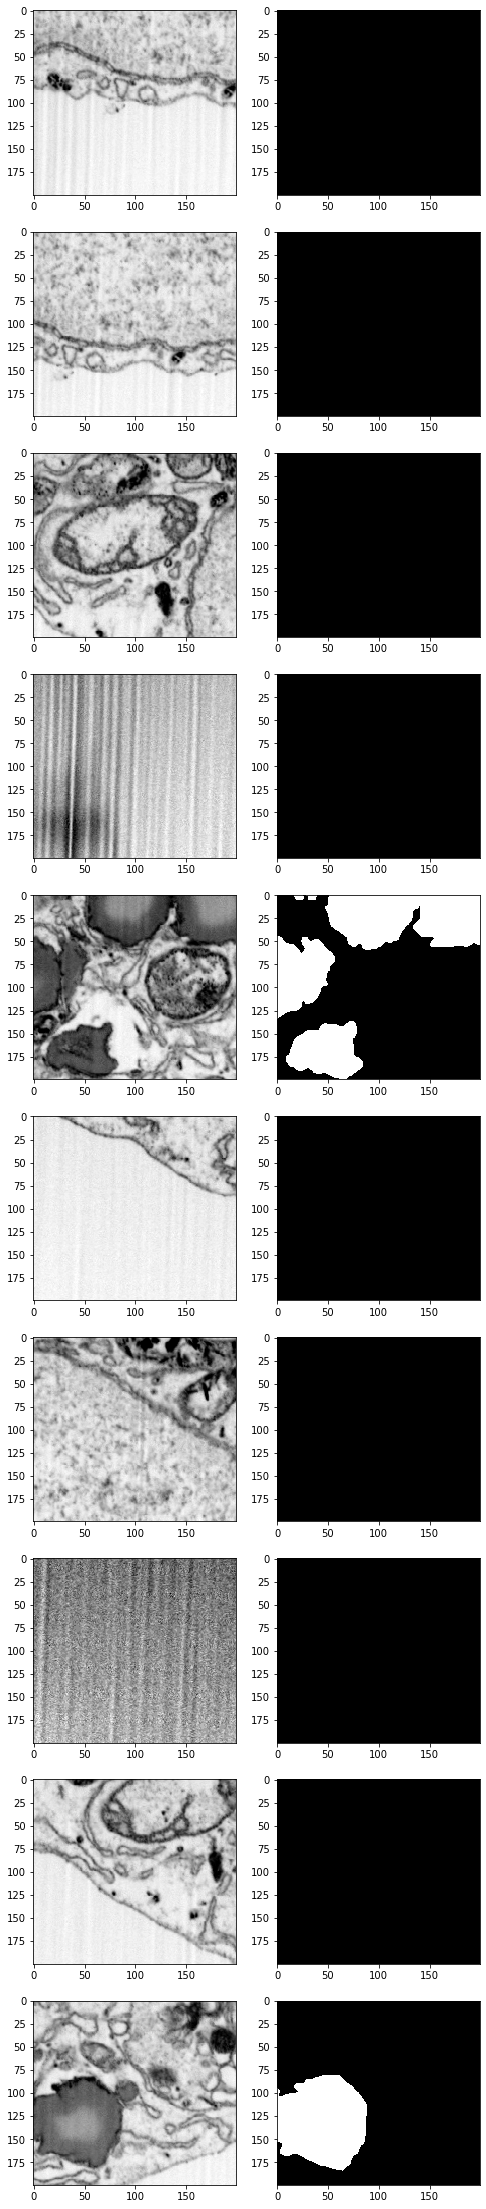

In [25]:
fig = plt.figure(figsize=(8, 40))

for idx, img_idx in enumerate(img_number_list):
    img_tmp = imread(opimglist[idx], as_gray = True)
    label_tmp = imread(oplabellist[idx], as_gray=True)
    
    a = fig.add_subplot(image_count, 2, idx*2 + 1)
    imgplot = plt.imshow(img_tmp, aspect='auto', cmap='gray')
    
    a = fig.add_subplot(image_count, 2, idx*2 + 2)
    imgplot = plt.imshow(label_tmp, vmin=0, vmax=1, aspect='auto', cmap='gray')